In [ ]:
#!wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
#!unzip imdb.zip
#!pip -q install eli5
# !pip -q install spacy
# !python -m spacy download en

Тут придется авторизировать запрос к гугл драйву, извините.

In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
#!pip install -U -q PyDrive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

#downloaded = drive.CreateFile({'id': '1d1-5FwxK53ePwygNWeG7jhsOWZbi5HOv'})
#downloaded.GetContentFile('train_docs.pkl')

#downloaded = drive.CreateFile({'id': '1MMOY477t965G0C5DtXeREVp0X85UaNq5'})
#downloaded.GetContentFile('test_docs.pkl')

# Классификация текстов

Начнём с самого простого - анализа тональности текста.

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [ ]:
import pandas as pd

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


Посмотрите глазами на тексты? Какие есть зацепки, как определить, что это за сентимент?

Самое простое, как всегда - найти ключевые слова.

In [ ]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'great', 'best', 'wonderful' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

Test accuracy = 66.73%


**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

In [ ]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'great', 'best', 'wonderful', 'superb', 'perfect', 'outstanding', \
                'incredible', 'funniest' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap', 'boring', 'waste', 'fails', \
                'disappointing', 'lame' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    try:
        display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))
    except:
        print('ERROR 404')

Test accuracy = 71.09%
ERROR 404


**Задание** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять

In [ ]:
import re

pattern = re.compile('<br\s?\/>|<br>')

print(train_df['review'].iloc[3])
print()
print(pattern.subn(' ', train_df['review'].iloc[3])[0])
print()


Spoilers ahead if you want to call them that...<br /><br />I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...<br /><br />THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or "effort".<br /><br />THE SCREENPLAY: I usually give credit to indie screenwriters, it's hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you'd uh...if you'd like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.<br /><br />THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one 

Применим ее:

In [ ]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

# Почистим текст.

In [ ]:
def words_only(text):
        return text.lower()   
train_df['review'] = train_df['review'].apply(words_only)
test_df['review'] = test_df['review'].apply(words_only)

def remove_punkt(text, ptrn):
    return re.sub(ptrn, ' ', text)

train_df['review'] = train_df['review'].apply(remove_punkt, ptrn=r'[^a-zA-Z0-9]')
test_df['review'] = test_df['review'].apply(remove_punkt, ptrn=r'[^a-zA-Z0-9]')

In [ ]:
import nltk
def to_token(text):
    return nltk.tokenize.word_tokenize(text)
train_df['review'] = train_df['review'].apply(to_token)
test_df['review'] = test_df['review'].apply(to_token)

In [ ]:
from nltk.corpus import stopwords

mystopwords = stopwords.words("english")
def remove_stopwords(text, stop_words = mystopwords):
    return [w for w in text if w not in stop_words]


train_df['review'] = train_df['review'].apply(remove_stopwords)
test_df['review'] = test_df['review'].apply(remove_stopwords)


def join_to_str(text_list):
    return ' '.join(word for word in text_list)

train_df['review'] = train_df['review'].apply(join_to_str)
test_df['review'] = test_df['review'].apply(join_to_str)



def remove_word(text, word):
    return text.replace(word,'')



train_df['review'] = train_df['review'].apply(remove_word, word="the")
test_df['review'] = test_df['review'].apply(remove_word, word="the")


train_df['review'] = train_df['review'].apply(remove_word, word="a")
test_df['review'] = test_df['review'].apply(remove_word, word="a")

train_df


,is_positive,review
0,0,dremgirls despite fistful tony wins incredibly...
1,0,show comes interesting loctions fst trvel chnn...
2,1,simply love movie lso love rmones sort bised b...
3,0,spoilers hed wnt cll would lmost recommend fil...
4,1,time fvorite movie seen mny movies one bets ex...
...,...,...
24995,1,big fn movie usul resons think trvolt winger p...
24996,0,going bor plot synopsis since know movie lmost...
24997,0,movie know would tke indellible chrcter pippi ...
24998,1,sw film dvd yesterdy gob smcked flbbergsted un...


Пора переходить к машинке!

Как будем представлять текст? Проще всего - мешком слов.

Заведём большой-большой словарь - список всех слов в обучающей выборке. Тогда каждое предложение можно представить в виде вектора, в котором будет записано, сколько раз встретилось каждое из возможных слов:

![bow](https://raw.githubusercontent.com/DanAnastasyev/DeepNLP-Course/master/Week%2001/Images/BOW.png)

Простой и приятный способ сделать это - запихнуть тексты в `CountVectorizer`.

Он имеет такую сигнатуру:

```python
CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=r'(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.int64'>)
```

Для начала обратим внимание на параметры `lowercase=True` и `max_df=1.0, min_df=1, max_features=None` - они про то, что по умолчанию все слова будут приводиться к нижнему регистру и в словарь попадут все слова, встречавшиеся в текстах.

При желании можно было бы убрать слишком редкие или слишком частотные слова - пока не будем этого делать.

Посмотрим на простом примере, как он будет работать:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


*Как именно vectorizer определяет границы слов? Обратите внимание на параметр `token_pattern=r'(?u)\b\w\w+\b'` - как он будет работать?*

Запустим его на реальных данных:

__The default regexp select tokens of 2
    or more alphanumeric characters__  
    (punctuation is completely ignored
    and always treated as a token separator).

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer()

Посмотрим на слова, попавшие в словарь:

In [ ]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

{k: v for k, v in sorted(words_counter.items(), key=lambda item: item[1], reverse=True)}

Words count 19639


{'movie': 44048,
 'film': 40162,
 'one': 26795,
 'like': 20433,
 'good': 15147,
 'time': 12735,
 'even': 12655,
 'would': 12448,
 'story': 11990,
 'relly': 11741,
 'see': 11480,
 'wy': 10821,
 'well': 10668,
 'much': 9766,
 'bd': 9341,
 'get': 9312,
 'people': 9287,
 'lso': 9159,
 'gret': 9096,
 'first': 9064,
 'mde': 8367,
 'mke': 8025,
 'could': 7929,
 'movies': 7668,
 'think': 7298,
 'chrcters': 7160,
 'chrcter': 7025,
 'wtch': 6975,
 'two': 6906,
 'films': 6889,
 'seen': 6681,
 'mny': 6675,
 'life': 6632,
 'best': 6603,
 'plot': 6589,
 'cting': 6494,
 'never': 6485,
 'love': 6454,
 'little': 6441,
 'show': 6295,
 'go': 6210,
 'know': 6167,
 'mn': 5993,
 'ever': 5992,
 'better': 5740,
 'end': 5651,
 'still': 5624,
 'sy': 5405,
 'scene': 5383,
 'long': 5228,
 'scenes': 5213,
 'fr': 5133,
 'something': 5076,
 'bck': 4981,
 'rel': 4739,
 'prt': 4655,
 'wtching': 4606,
 'though': 4566,
 'yers': 4532,
 'thing': 4529,
 'old': 4526,
 'ctors': 4488,
 'director': 4449,
 'nor': 4378,
 'work':

Попробуем кого-нибудь таки сконвертировать

In [ ]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x71042 sparse matrix of type '<class 'numpy.int64'>'
	with 149 stored elements in Compressed Sparse Row format>

То, что и хотели - вектор с bow (т.е. bag-of-words) представлением исходного текста.

И чем эта информация может помочь? Ну, всё тем же - какие-то слова носят положительный окрас, какие-то - отрицательный. Большинство вообще нейтральный, да.

![bow with weights](https://github.com/DanAnastasyev/DeepNLP-Course/raw/master/Week%2001/Images/BOW_weights.png)

Хочется, наверное, подобрать коэффициенты, которые будут определять уровень окраса, да? Подбирать нужно по обучающей выборке, а не как мы перед этим делали.

Например, для выборки
```
1   The movie was excellent
0   the movie was awful
```
легко подобрать коэффициенты на глазок: что-нибудь вроде `+1` для `excellent`,  `-1` для `awful` и по нулям всем остальным.

Построим линейную модель, которая станет этим заниматься. Она будет учиться строить разделяющую гиперплоскость в пространстве bow-векторов.

Проверим, как справится логистическая регрессия с нашей супер-выборкой из пары предложений

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie', 'the', 'was']
[[-0.40104279  0.40104279  0.          0.          0.        ]]


Получилось что надо.

Запустим теперь её на реальных данных.

In [ ]:
model.fit(train_df['review'], train_df['is_positive'])

/home/nicolay/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

In [ ]:
from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
eval_model(model, test_df)

Test accuracy = 86.21%


Прогресс!

Хочется как-то посмотреть, что заинтересовало классификатор. К счастью, сделать это совсем просто:

In [ ]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=30)

Посмотрим на конкретные примеры его работы:

In [ ]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [ ]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


Посмотрим на примеры неправильной классификации, наконец:

In [ ]:
import numpy as np

preds_C = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds_C != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

In [ ]:
errors_info = test_df.copy()

In [ ]:
errors_info['CountVectorizer_pred'] = preds_C
#errors_info

## Придумываем новые признаки

### Tf-idf

Сейчас мы на все слова смотрим с одинаковым весом - хотя какие-то из них более редкие, какие-то более частые, и эта частотность - полезная, вообще говоря, информация.

Самый простой способ добавить статистическую информацию о частотностях - сделать *tf-idf* взвешивание:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* - term-frequency - частотность слова `t` в конкретном документе `d` (рецензии в нашем случае). Это ровно то, что мы уже считали.

*idf* - inverse document-frequency - коэффициент, который тем больше, чем в меньшем числе документов встречалось данное слово. Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
где $n_d$ - число всех документов, а $n_{d(t)}$ - число документов со словом `t`.

Использовать его просто - нужно заменить `CountVectorizer` на `TfidfVectorizer`.

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.36%


In [ ]:
preds_T = model.predict(test_df['review'])

In [ ]:
errors_info['TfidfVectorizer_pred'] = preds_T
#errors_info

In [ ]:
errors_info = errors_info[errors_info['TfidfVectorizer_pred'] != errors_info['CountVectorizer_pred']]
errors_info

,is_positive,review,CountVectorizer_pred,TfidfVectorizer_pred
10,0,bor check logic none hnd mny relly gret movies...,1,0
40,0,child 1980s grew numerous eductionl well diver...,0,1
72,1,sw film relesed minor cinems uk 50 yers go mem...,0,1
81,1,one better teen comedies filmed 80 vlley girl ...,0,1
145,0,first porn ever tried review demnds different ...,1,0
...,...,...,...,...
24947,0,ok little men like 2 3 6 7 brney one fvorite s...,0,1
24950,0,well movie horrible thought would expecting gi...,1,0
24955,0,prtment complex cmpy comedy full kookie chrcte...,0,1
24963,1,going wtch film michel cine michel gmbon bor t...,0,1


### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.11%


### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

Например, слово `badass` мы можем представить в виде такой последовательности триграмм:

`##b #ba bad ada das ass ss# s##`

So interpretable, неправда ли?

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 87.41%


In [ ]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


## Подключаем лингвистику

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [ ]:
from tqdm.notebook import trange, tqdm
import spacy
from spacy import displacy

#nlp = spacy.load('en', disable=['parser'])
nlp = spacy.load("en_core_web_sm")

### Предпочитаю делать все на локальной машине и поэтому данные были рассчитаны а не загружены.

In [ ]:
import pickle


try:
    with open('train_docs.pkl', 'rb') as f:
        train_docs = pickle.load(f)
except:
    train_docs = [doc for doc in tqdm(nlp.pipe(train_df.review.values[:]))]    
    with open('train_docs.pkl', 'wb') as f:
        pickle.dump(train_docs, f)
    
    
try:    
    with open('test_docs.pkl', 'rb') as f:
        test_docs = pickle.load(f)
except:
    test_docs = [doc for doc in tqdm(nlp.pipe(test_df.review.values[:]))]    
    with open('test_docs.pkl', 'wb') as f:
        pickle.dump(test_docs, f)


**Задание** Сделайте классификатор на лемматизированных текстах.

Более простой способ нормализации слов - использовать стемминг. Он немного тупой, не учитывает контекст, но иногда оказывается даже эффективнее лемматизации - а, главное, быстрее.

По сути это просто набор правил, как обрезать слово, чтобы получить основу (stem):

In [ ]:
docs_lem=[]
for doc in train_docs:
    text_lem=[]
    for token in doc:
        text_lem.append(token.lemma_)    
    text_lem = ' '.join(word for word in text_lem)
    docs_lem.append(text_lem)

train_df['text_lem'] = docs_lem
#train_df 

In [ ]:
docs_lem=[]
for doc in test_docs:
    text_lem=[]
    for token in doc:
        text_lem.append(token.lemma_)    
    text_lem = ' '.join(word for word in text_lem)
    docs_lem.append(text_lem)

test_df['text_lem'] = docs_lem
#test_df 

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['text_lem'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 86.13%


In [ ]:
from nltk import PorterStemmer

stemmer = PorterStemmer()

print(stemmer.stem('become'))
print(stemmer.stem('becomes'))
print(stemmer.stem('became'))

becom
becom
becam


**Задание** Попробуйте вместо лемм классифицировать основы.

In [ ]:
docs_Stemm=[]
for doc in tqdm(train_docs):
    text_Stemm=[]
    for token in doc:
        text_Stemm.append(stemmer.stem(token.text))    
    text_Stemm = ' '.join(word for word in text_Stemm)
    docs_Stemm.append(text_Stemm)

train_df['text_Stemm'] = docs_Stemm
#train_df 

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
docs_Stemm=[]
for doc in tqdm(test_docs):
    text_Stemm=[]
    for token in doc:
        text_Stemm.append(stemmer.stem(token.text))    
    text_Stemm = ' '.join(word for word in text_Stemm)
    docs_Stemm.append(text_Stemm)

test_df['text_Stemm'] = docs_Stemm
#test_df 

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['text_Stemm'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 83.26%


### NER

В текстах рецензий очень много именованных сущностей. Вот, например:

In [ ]:
displacy.render(train_docs[0], style='ent', jupyter=True)

Вообще говоря, почему вдруг какой-нибудь Депп должен нести семантическую окраску? Однако оказывается, что классификатор выучивает, что какие-то имена чаще в положительных рецензиях - или наоборот. Это похоже на переобучение - почему бы не попробовать вырезать сущности?

**Задание** Удалите из текстов какие-то из сущностей, пользуясь координатами из запикленных файлов. Описание сущностей можно посмотреть [здесь](https://spacy.io/api/annotation#named-entities). Запустите классификатор.

In [ ]:
new_train_docs = []
for i, doc in tqdm(enumerate((train_docs))):
    plain_text=''
    start_point=0
    for ent in doc.ents:
        plain_text = plain_text+train_df.iloc[i]['review'][start_point : ent.start_char]+' '+ent.label_+' '
        start_point = ent.end_char   
    new_train_docs.append(plain_text)
    
#new_train_docs[0]    

0it [00:00, ?it/s]

In [ ]:
new_test_docs = []
for i, doc in tqdm(enumerate((test_docs))):
    plain_text=''
    start_point=0
    for ent in doc.ents:
        plain_text = plain_text+test_df.iloc[i]['review'][start_point : ent.start_char]+' '+ent.label_+' '
        start_point = ent.end_char   
    new_test_docs.append(plain_text)
    


0it [00:00, ?it/s]

In [ ]:
train_df['no_ner_text'] = new_train_docs
test_df['no_ner_text']  = new_test_docs

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['no_ner_text'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 87.62%


In [ ]:
train_df

,is_positive,review,text_lem,text_Stemm,no_ner_text
0,0,dremgirls despite fistful tony wins incredibly...,dremgirl despite fistful tony win incredibly w...,dremgirl despit fist toni win incred wek yer b...,dremgirls despite fistful tony wins incredibly...
1,0,show comes interesting loctions fst trvel chnn...,show come interesting loction fst trvel chnnel...,show come interest loction fst trvel chnnel bi...,show comes interesting loctions fst trvel chnn...
2,1,simply love movie lso love rmones sort bised b...,simply love movie lso love rmone sort bise beg...,simpli love movi lso love rmone sort bise begi...,simply love movie lso love rmones sort bised b...
3,0,spoilers hed wnt cll would lmost recommend fil...,spoiler he d wnt cll would lmost recommend fil...,spoiler he d wnt cll would lmost recommend fil...,spoilers hed wnt ORG would lmost recommend f...
4,1,time fvorite movie seen mny movies one bets ex...,time fvorite movie see mny movie one bet excel...,time fvorit movi seen mni movi one bet excel c...,
...,...,...,...,...,...
24995,1,big fn movie usul resons think trvolt winger p...,big fn movie usul reson think trvolt winger pe...,big fn movi usul reson think trvolt winger per...,big fn movie usul resons think trvolt winger p...
24996,0,going bor plot synopsis since know movie lmost...,go bor plot synopsis since know movie lmost pl...,go bor plot synopsi sinc know movi lmost plot ...,going bor plot synopsis since know movie lmost...
24997,0,movie know would tke indellible chrcter pippi ...,movie know would tke indellible chrcter pippi ...,movi know would tke indel chrcter pippi longst...,
24998,1,sw film dvd yesterdy gob smcked flbbergsted un...,sw film dvd yesterdy gob smcke flbbergste unff...,sw film dvd yesterdi gob smcked flbbergst unff...,sw film dvd yesterdy gob smcked flbbergsted un...


In [ ]:
#for ent in docs[0].ents:
#    print(ent.text, ent.start_char, ent.end_char, ent.label_)

## Включаем дип лёрнинг

Мы тут пришли deep learning'ом заниматься, а делаем почему-то модель на логистической регрессии. Как так?

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

In [ ]:
train_df['review']

0        dremgirls despite fistful tony wins incredibly...
1        show comes interesting loctions fst trvel chnn...
2        simply love movie lso love rmones sort bised b...
3        spoilers hed wnt cll would lmost recommend fil...
4        time fvorite movie seen mny movies one bets ex...
                               ...                        
24995    big fn movie usul resons think trvolt winger p...
24996    going bor plot synopsis since know movie lmost...
24997    movie know would tke indellible chrcter pippi ...
24998    sw film dvd yesterdy gob smcked flbbergsted un...
24999    disppointment none nunce originl brits seem bl...
Name: review, Length: 25000, dtype: object

<BarContainer object of 250 artists>

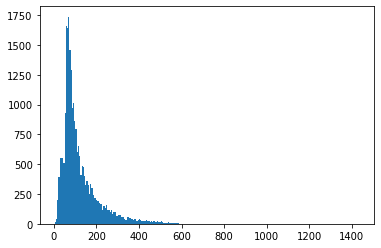

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

Кроме этого, нужно перенумеровать как-то слова.

In [ ]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 19639


**Задание** Сконвертируйте данные

In [ ]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [ ]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

In [ ]:
dim = int(len(word2idx)**(1/2))

model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=dim, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 140)         2749460   
_________________________________________________________________
global_max_pooling1d (Global (None, 140)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1410      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 2,750,991
Trainable params: 2,750,991
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive), callbacks=[callback])

Epoch 1/10
196/196 [==============================] - 64s 310ms/step - loss: 0.5298 - accuracy: 0.8024 - val_loss: 0.3164 - val_accuracy: 0.8687
Epoch 2/10
196/196 [==============================] - 56s 287ms/step - loss: 0.2418 - accuracy: 0.9058 - val_loss: 0.2718 - val_accuracy: 0.8861
Epoch 3/10
196/196 [==============================] - 56s 287ms/step - loss: 0.1413 - accuracy: 0.9506 - val_loss: 0.2796 - val_accuracy: 0.8863
Epoch 4/10
196/196 [==============================] - 56s 288ms/step - loss: 0.0696 - accuracy: 0.9808 - val_loss: 0.3108 - val_accuracy: 0.8833
Epoch 5/10
196/196 [==============================] - 56s 287ms/step - loss: 0.0269 - accuracy: 0.9958 - val_loss: 0.3520 - val_accuracy: 0.8811


**Задание** Подсчитайте качество модели на тесте

In [ ]:
model.evaluate(X_test, test_df.is_positive)

782/782 [==============================] - 21s 26ms/step - loss: 0.2718 - accuracy: 0.8861


[0.2717968225479126, 0.8861200213432312]

In [ ]:
X_train = convert(train_df.text_lem, word2idx, 1000)
X_test = convert(test_df.text_lem, word2idx, 1000)

In [ ]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive), callbacks=[callback])

Epoch 1/10
196/196 [==============================] - 57s 293ms/step - loss: 0.2043 - accuracy: 0.9212 - val_loss: 0.2990 - val_accuracy: 0.8734
Epoch 2/10
196/196 [==============================] - 56s 286ms/step - loss: 0.1102 - accuracy: 0.9638 - val_loss: 0.3341 - val_accuracy: 0.8689
Epoch 3/10
196/196 [==============================] - 75s 383ms/step - loss: 0.0476 - accuracy: 0.9886 - val_loss: 0.3830 - val_accuracy: 0.8640
Epoch 4/10
196/196 [==============================] - 70s 357ms/step - loss: 0.0176 - accuracy: 0.9981 - val_loss: 0.4290 - val_accuracy: 0.8628


In [ ]:
model.evaluate(X_test, test_df.is_positive)

782/782 [==============================] - 25s 32ms/step - loss: 0.2990 - accuracy: 0.8734


[0.2989976108074188, 0.8733999729156494]

In [ ]:
X_train = convert(train_df.no_ner_text, word2idx, 1000)
X_test = convert(test_df.no_ner_text, word2idx, 1000)

In [ ]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive), callbacks=[callback])

Epoch 1/10
196/196 [==============================] - 69s 350ms/step - loss: 0.2480 - accuracy: 0.8856 - val_loss: 0.4066 - val_accuracy: 0.8103
Epoch 2/10
196/196 [==============================] - 66s 338ms/step - loss: 0.1369 - accuracy: 0.9405 - val_loss: 0.4549 - val_accuracy: 0.8113
Epoch 3/10
196/196 [==============================] - 66s 338ms/step - loss: 0.0816 - accuracy: 0.9584 - val_loss: 0.5181 - val_accuracy: 0.8018
Epoch 4/10
196/196 [==============================] - 66s 337ms/step - loss: 0.0621 - accuracy: 0.9622 - val_loss: 0.5567 - val_accuracy: 0.8040


In [ ]:
model.evaluate(X_test, test_df.is_positive)

782/782 [==============================] - 25s 32ms/step - loss: 0.4066 - accuracy: 0.8103


[0.40658092498779297, 0.8103200197219849]

In [ ]:
X_train = convert(train_df.review, word2idx, 400)
X_test = convert(test_df.review, word2idx, 400)

In [ ]:
import tensorflow.keras.layers as L
from tensorflow.keras import Model
inputs = L.Input(shape=(X_train.shape[1],))

x = Embedding(input_dim=len(word2idx), output_dim=dim)(inputs)
dropout_embeds = L.SpatialDropout1D(0.05)(x)
x = L.Bidirectional(L.LSTM(units=7, return_sequences=True))(dropout_embeds)
pooled_avg_sequences = L.GlobalAveragePooling1D()(x)
pooled_max_sequences = L.GlobalMaxPooling1D()(x)
concated = L.concatenate([pooled_avg_sequences, pooled_max_sequences])
dense_intermediate = L.Dense(64, activation='elu')(concated)
x = L.Dense(1, activation='sigmoid')(dense_intermediate)

model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 140)     2749460     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 400, 140)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 400, 14)      8288        spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [ ]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=5, 
          validation_data=(X_test, test_df.is_positive), callbacks=[callback])

Epoch 1/5
196/196 [==============================] - 128s 624ms/step - loss: 0.4089 - accuracy: 0.8074 - val_loss: 0.2856 - val_accuracy: 0.8802
Epoch 2/5
196/196 [==============================] - 120s 614ms/step - loss: 0.1601 - accuracy: 0.9413 - val_loss: 0.3085 - val_accuracy: 0.8732
Epoch 3/5
196/196 [==============================] - 120s 614ms/step - loss: 0.0765 - accuracy: 0.9763 - val_loss: 0.4048 - val_accuracy: 0.8642
Epoch 4/5
196/196 [==============================] - 120s 614ms/step - loss: 0.0336 - accuracy: 0.9909 - val_loss: 0.5320 - val_accuracy: 0.8604


In [ ]:
model.evaluate(X_test, test_df.is_positive)

782/782 [==============================] - 94s 120ms/step - loss: 0.2856 - accuracy: 0.8802


[0.28564682602882385, 0.8802400231361389]

# Выводы.

1. На точность результата очень сильно влияет какая предобработка текста была выполнена.
2. Для каждой модели требуется своя-уникальная предобработка.
3. Лематизация, стеминг, замена NER значимых улучшений не принесли.
4. Лучше всего себя показали логистическая регрессия поверх TFIDF и некоторые варианты NN.